<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>NMF-Based Audio Decomposition</h1> 
</div>

<br/>

<p>
Following Section 8.3.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we describe a score-informed NMF procedure for decomposing an audio signal into note-based sound events. This procedure was originally described by Ewert and Müller. As shown by Driedger et al., such a decomposition can be used for audio editing applications. 
    
<ul>
<li><span style="color:black">
Sebastian Ewert, Meinard Müller: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2012_EwertMueller_ScoreConstrainedNMF_ICASSP.pdf"><strong>Using Score-Informed Constraints for NMF-based Source Separation.</strong> </a>Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP), Kyoto, Japan, 129&ndash;132, 2012.
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_EwertM12_ScoreInformedNMF_ICASSP.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="http://resources.mpi-inf.mpg.de/MIR/ICASSP2012-ScoreInformedNMF/">Demo Website with Sound Examples</a>
</span></li>
</ul> 

<ul>
<li><span style="color:black">
Jonathan Driedger, Harald Grohganz, Thomas Prätzlich, Sebastian Ewert, Meinard Müller: <strong>Score-Informed Audio Decomposition and Applications.</strong> Proceedings of the ACM International Conference on Multimedia, Barcelona, Spain, 541&ndash;544, 2013.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_DriedgerGPEM13_AudioDecomposition_ACM-MM.txt"> Bibtex </a><a type="button" class="btn btn-default btn-xs" target="_blank" href="https://www.youtube.com/watch?v=g1H-7773gpo">Video</a>
</span></li>
</ul>  

<ul>
<li><span style="color:black">
Sebastian Ewert, Bryan Pardo, Meinard Müller, Mark Plumbley: <strong>Score-Informed Source Separation for Musical Audio Recordings.</strong> IEEE Signal Processing Magazine, 31(3): 116&ndash;124, 2014.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_EwertPMP14_SourceSeparation_IEEE-SPS.txt"> Bibtex </a>
</span></li>
</ul> 
</p> 

## Introduction

In the [FMP notebook on NMF-based spectrogram factorization](../C8/C8S3_NMFSpecFac.html), we used score annotations to constrain the** template matrix** (using pitches) and the **activation matrix** (using note start positions and note durations). This resulted in a decomposition of the magnitude spectrum $V$ into musically meaningful template matrix $W$ and activation matrix $H$. In particular, the notewise activation constraints yield a mapping between nonzero coefficients in $H$ and the score's note events. We now describe how this spectrogram decomposition can be employed to separate audio components that correspond to specific note groups. These note groups, which may encode a melody line, a certain motif, or the accompaniment, may be specified by means of a suitable labeling of the score representation. 

As an illustrative scenario, we continue with the [Chopin example](../C8/C8S3_NMFSpecFac.html), the beginning of the Prélude Op. 28, No. 4. Our goal is to decompose the recording into two components, where one component corresponds to the notes of the lower staff (the accompaniment played by the left hand of the pianist, indicated by the red box) and the other to the notes of the upper staff (the melody played by the right hand, indicated by yellow box). 

<img src="../data/C8/FMP_C8_F26a.png" width="320px" align="left" alt="FMP_C8_F26a">

<br clear="all" />

<audio style="width: 320px;" src="../data/C8/FMP_C8_F27_Chopin_Op028-04_minor.mp3" type="audio/mpeg" controls="controls"></audio>

## Score-Informed Spectrogram Factorization

As input to the NMF algorithm, we use a ([logarithmically compressed](../C3/C3S1_LogCompression.html)) magnitude spectrogram. Furthermore, we use an [onset model](../C8/C8S3_NMFSpecFac.html) with [score-informed template and activation constraints](../C8/C8S3_NMFSpecFac.html) as described in Section 8.3.2.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. In the following code cell, we show the resulting score-informed spectrogram factorization.

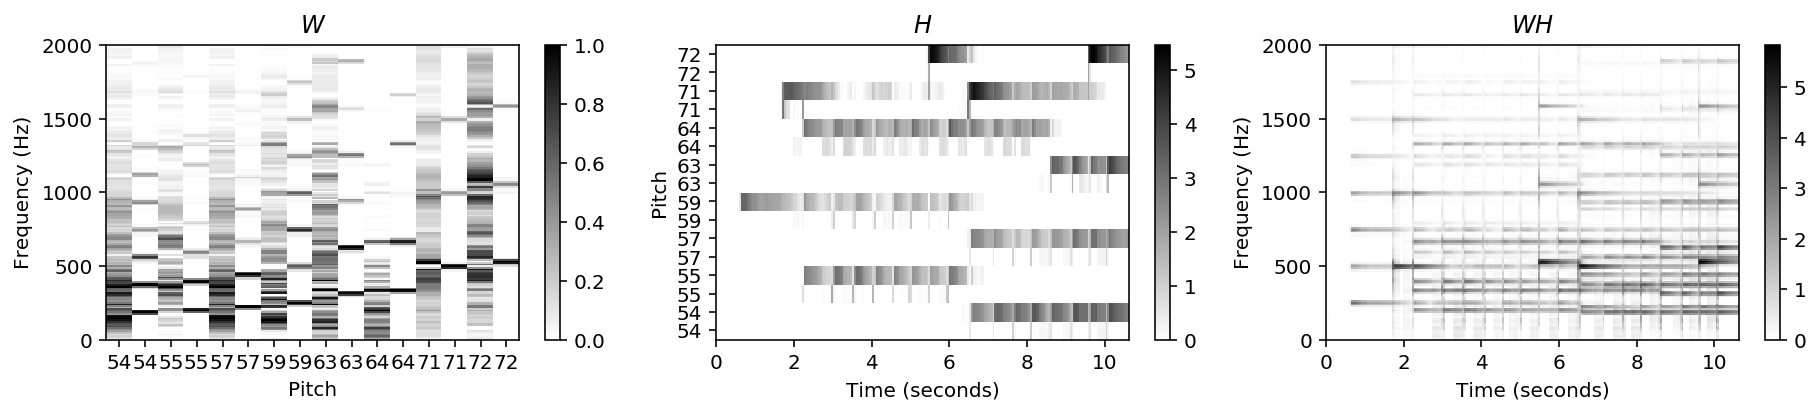

In [1]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
sys.path.append('..')
import libfmp.b
import libfmp.c1
import libfmp.c8
%matplotlib inline

Fs = 22050
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.wav')
#fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD.wav')

fn_ann = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD_beginning.csv')
#fn_ann = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Chopin_Op028-04_SMD.csv')
annotation = libfmp.c1.csv_to_list(fn_ann)

# Input Spectrogram
x, Fs = librosa.load(fn_wav, sr=Fs)
N_fft = 2048
H_fft = 1024
X = librosa.stft(x, n_fft=N_fft, hop_length=H_fft)
V = np.log(1 + np.abs(X))
#V = np.abs(X)
freq_res = Fs / N_fft
freq_max = 2000
frame_res = H_fft/Fs

#libfmp.b.plot_matrix(V, Fs=Fs/H_fft, Fs_F=N_fft/Fs)
#plt.ylim([0, freq_max]);

# NMF decomposition using onset model
K = V.shape[0]
N = V.shape[1]
pitch_set = libfmp.c8.pitch_from_annotation(annotation)
R = pitch_set.shape[0]

H_init, pitch_set, label_pitch = libfmp.c8.init_nmf_activation_score_onset(N, annotation, frame_res, 
                                                    tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1])
W_init = libfmp.c8.init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05)

W, H, V_approx, V_approx_err, H_W_error = libfmp.c8.nmf(V, 2*R, W=W_init, H=H_init, L=100, norm=True)
#libfmp.c8.plot_nmf_factors(W_init, H_init, W_init.dot(H_init), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch)
libfmp.c8.plot_nmf_factors(W, H, W.dot(H), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch, 
                           title_W=r'$W$', title_H=r'$H$', title_V=r'$WH$')

## Score-Informed Split of Activation Matrix

Using the mapping between the activation constraints in $H$ and the score's notes, we can split up $H$ into two matrices $H^\mathrm{L}$ and $H^\mathrm{R}$, which contain the activations for the left and for the right hand, respectively. Multiplying these two matrices with the template matrix $W$, we obtain two matrices $WH^\mathrm{L}$ and $WH^\mathrm{R}$. Intuitively, these two matrices can be regarded as the estimated magnitude STFTs for the desired components for the left and right hand, respectively. In the following code cell, we provide an implementation of this score-informed split of the activation matrix. 

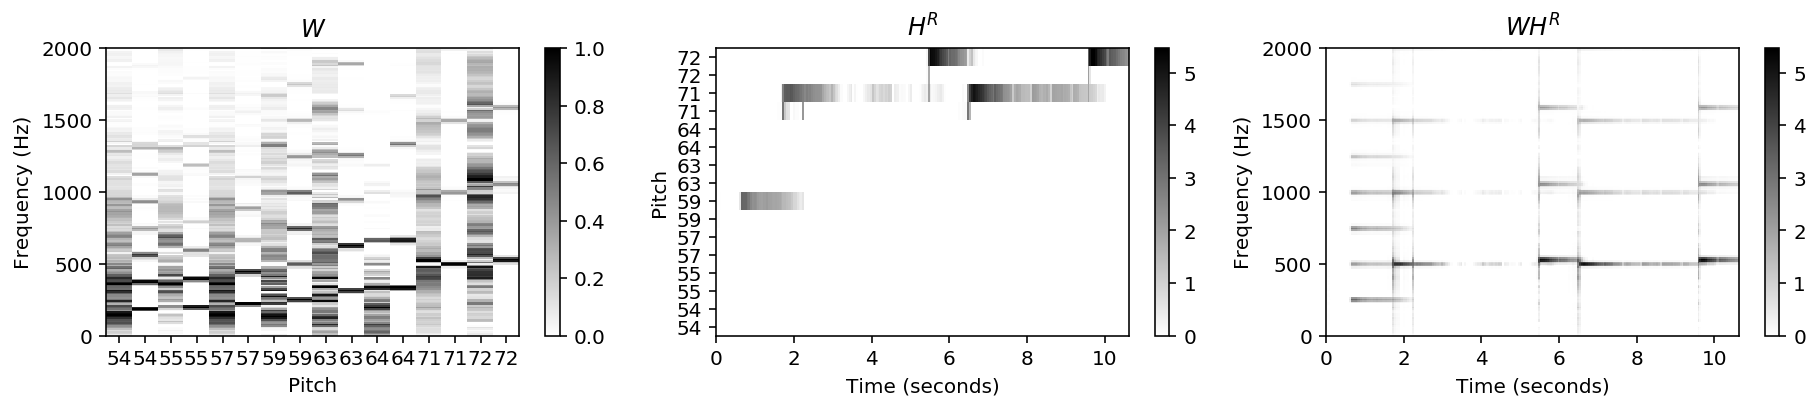

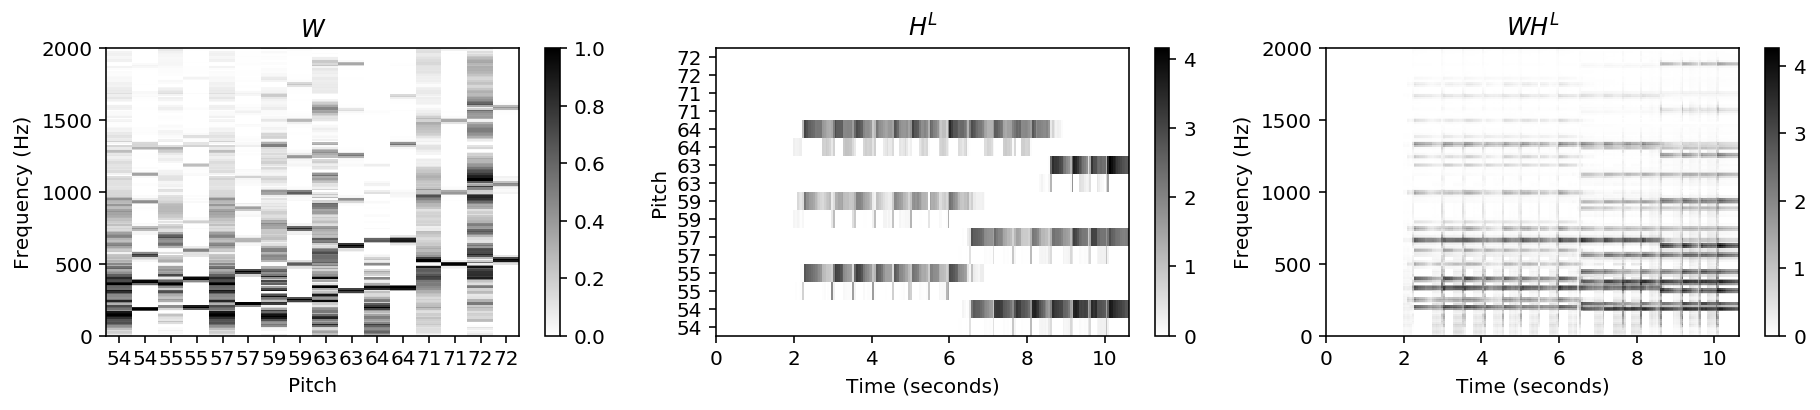

In [2]:
def split_annotation_lh_rh(ann):
    """Splitting of the annotation data in left and right hand

    Notebook: C8/C8S3_NMFAudioDecomp.ipynb

    Args:
        ann (list): Annotation data

    Returns:
        ann_lh (list): Annotation data for left hand
        ann_rh (list): Annotation data for right hand
    """
    ann_lh = []
    ann_rh = []
    for a in ann:
        if a[4] == 'lh':
            ann_lh = ann_lh + [a]
        if a[4] == 'rh':
            ann_rh = ann_rh + [a]
    return ann_lh, ann_rh

annotation_lh, annotation_rh = split_annotation_lh_rh(annotation)

H_init_L, pitch_set_L, label_pitch_L = libfmp.c8.init_nmf_activation_score_onset(N, annotation_lh, frame_res, 
                                            tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1], pitch_set=pitch_set)
H_init_R, pitch_set_R, label_pitch_R = libfmp.c8.init_nmf_activation_score_onset(N, annotation_rh, frame_res, 
                                            tol_note=[0.1, 0.5], tol_onset=[0.2, 0.1], pitch_set=pitch_set)

H_L = H * H_init_L
H_R = H * H_init_R

libfmp.c8.plot_nmf_factors(W, H_R, W.dot(H_R), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch, 
                           title_W=r'$W$', title_H=r'$H^R$', title_V=r'$WH^R$')
libfmp.c8.plot_nmf_factors(W, H_L, W.dot(H_L), Fs, N_fft, H_fft, freq_max, label_pitch=label_pitch, 
                           title_W=r'$W$', title_H=r'$H^L$', title_V=r'$WH^L$')


## Spectral Masking

To obtain time-domain signals, a first idea is to simply use the phase information of the [original STFT](../C2/C2_STFT-Basic.html) $\mathcal{X}$ and to invert the resulting modified STFTs by applying the [**signal reconstruction**](../C8/C8S1_SignalReconstruction.html) method as described in Section 8.1.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. However, NMF-based models typically yield only a rough approximation of the 
original magnitude spectrogram (or even a logarithmically compressed version thereof), where spectral nuances or the actual magnitudes may not be captured well. Therefore, the audio components reconstructed in this way may contain a number of audible artifacts. Some of these artifacts may be removed or attenuated by using [**masking techniques**](../C8/C8S1_HPS.html) as discussed in Section 8.1.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. Instead of directly using $WH^\mathrm{L}$ and $WH^\mathrm{R}$ for the reconstruction, the idea is to use these matrices to first define the two **soft masks**

\begin{eqnarray}
    M^\mathrm{L} &:=& (W H^\mathrm{L})\oslash (W H + \varepsilon), \\
    M^\mathrm{R} &:=& (W H^\mathrm{R})\oslash (W H + \varepsilon),
\end{eqnarray}

where the operator $\oslash$ denotes pointwise division and the small positive value $\varepsilon>0$ is added to avoid division by zero. The two soft masks can then be applied to the original STFT $\mathcal{X}$ (as described in the [FMP notebook on harmonic&dash;percussive separation](../C8/C8S1_HPS.html)). Employing an [inverse STFT](../C8/C8S1_SignalReconstruction.html), one obtains the two desired time-domain component signals for the left and the right hand notes, respectively. By using the masking-based approach, many of the spectral details of the original recording are preserved, even if they are not directly captured by the factors of the NMF decomposition. This often yields more acoustically appealing results. On the downside, by filtering the original audio data, masking may also retain more nontarget spectral components compared with a direct reconstruction from $WH^\mathrm{L}$ and $WH^\mathrm{R}$.

<!--<img src="../data/C8/FMP_C8_F26b-d.png" width="500px" align="middle" alt="FMP_C8_F26b-d">-->

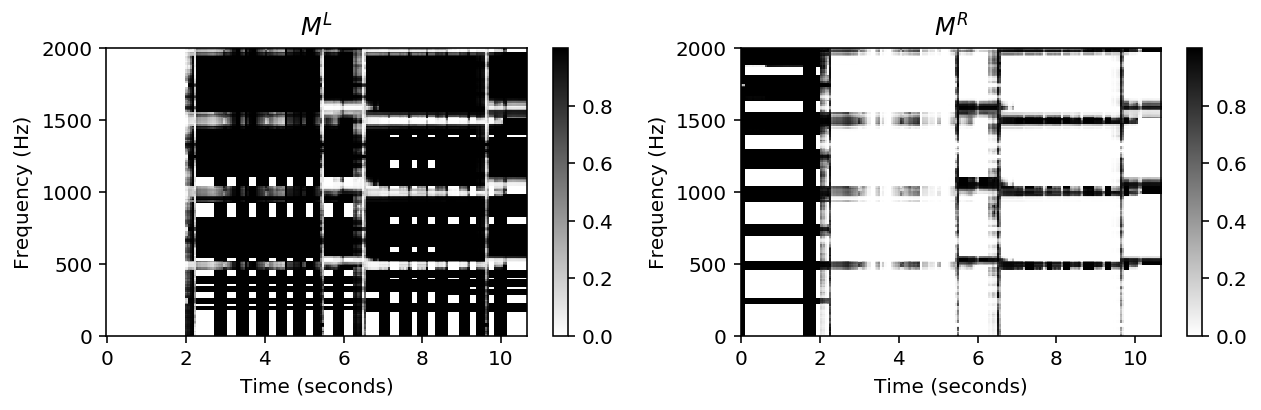

Original signal:


Reconstructed signal for left hand:


Reconstructed signal for right hand:


In [3]:
eps_machine = np.finfo(np.float32).eps
M_L = W.dot(H_L) / (W.dot(H) + eps_machine)
X_L = X * M_L
x_L = librosa.istft(X_L, hop_length=H_fft, win_length=N_fft, length=x.size)

M_R = W.dot(H_R) / (W.dot(H) + eps_machine)
X_R = X * M_R
x_R = librosa.istft(X_R, hop_length=H_fft, win_length=N_fft, length=x.size)

plt.figure(figsize=(9,3))
ax = plt.subplot(1,2,1)
libfmp.b.plot_matrix(M_L, Fs=Fs/H_fft, Fs_F=N_fft/Fs, ax=[ax], title=r'$M^L$')
ax.set_ylim([0, freq_max]);

ax = plt.subplot(1,2,2)
libfmp.b.plot_matrix(M_R, Fs=Fs/H_fft, Fs_F=N_fft/Fs, ax=[ax], title=r'$M^R$')
ax.set_ylim([0, freq_max]);
plt.tight_layout()
plt.show()

print('Original signal:')
ipd.display( ipd.Audio(x, rate=Fs) )
print('Reconstructed signal for left hand:')
ipd.display( ipd.Audio(x_L, rate=Fs) )
print('Reconstructed signal for right hand:')
ipd.display( ipd.Audio(x_R, rate=Fs) )

## Audio Editing

The availability of score information can not only be exploited for the separation process, but also offers user-friendly access for interactive audio processing applications. This is demonstrated by the following example, where a user can specify the desired audio manipulation within the score simply by editing some of the notes. Based on a **notewise audio decomposition**, the same manipulations can then be automatically transferred to a given audio recording. 

* To this end, the original recording is first decomposed into the notewise audio events of the manipulated notes and a remainder component. 
* Subsequently, the original pitch of each of the notewise audio events is suitably raised or lowered according to the specified score manipulations. Such sound modification techniques are also known as **pitch shifting**. 
* Finally, the modified audio events are added back to the remainder component. 

By using similar strategies, it is also possible to change the duration or the volume of notes, to remove notes completely from the audio recording, or to add additional notes by copying and manipulating existing ones. 

Continuing our Chopin example, the following sound examples illustrate the potential of score-informed audio editing. The piece originally written in $\mathrm{E}$-minor was converted into $\mathrm{E}$-major by changing the **key signature** from one sharp to four sharps. This shifts the note $\mathrm{C}5$ to $\mathrm{C}^\sharp 5$ and the note $\mathrm{G}3$ to $\mathrm{G}^\sharp 3$.

<img src="../data/C8/FMP_C8_F27.png" width="640px" align="left" alt="FMP_C8_F27">


<br clear="all" />

<audio style="width: 320px;" src="../data/C8/FMP_C8_F27_Chopin_Op028-04_minor.mp3" type="audio/mpeg" controls="controls"></audio>
<audio style="width: 320px;" src="../data/C8/FMP_C8_F27_Chopin_Op028-04_major.mp3" type="audio/mpeg" controls="controls"></audio>

More details on this application can be found in the original paper "Score-Informed Audio Decomposition and Applications" by Driedger et al. and the video below.

In [4]:
import IPython.display as ipd
ipd.display(ipd.YouTubeVideo('g1H-7773gpo?t=35', width=600, height=450))

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Tim Zunner.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>